In [1]:
import cv2
import numpy as np
from shapely.geometry.polygon import Polygon
from descartes import PolygonPatch
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cv2.__version__

'3.3.1'

In [3]:
def detect_edge(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #blurr = cv2.GaussianBlur(gray, (7,7), 2)
    bilateral = cv2.bilateralFilter(gray, 5, 5,5)
    eq = cv2.equalizeHist(bilateral)
    edged = cv2.Canny(eq, 0, 150)
    return edged, eq

def find_extremes(cnt):
    leftmost = tuple(cnt[cnt[:,0].argmin()])
    rightmost = tuple(cnt[cnt[:,0].argmax()])
    topmost = tuple(cnt[cnt[:,1].argmin()])
    bottommost = tuple(cnt[cnt[:,1].argmax()])
    return topmost[1], bottommost[1], leftmost[0], rightmost[0]

def supress_list(list_contours):
    suppress = list()
    for i in range(len(list_contours)):
        polygonA = Polygon([(boxi[0], boxi[1]) for boxi in list_contours[i]])
        for j in range(i+1,len(list_contours)):
            polygonB = Polygon([(boxi[0], boxi[1]) for boxi in list_contours[j]])
            #print(i, j, polygonA.intersection(polygonB).area/(polygonA.area))
            if (polygonA.intersection(polygonB).area/(polygonA.area) > 0.9):
                suppress.append(i)
                
    suppress = np.unique(suppress)
    list_contours = np.delete(list_contours, suppress, 0)
    return list_contours

In [4]:
img = cv2.imread('cni.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

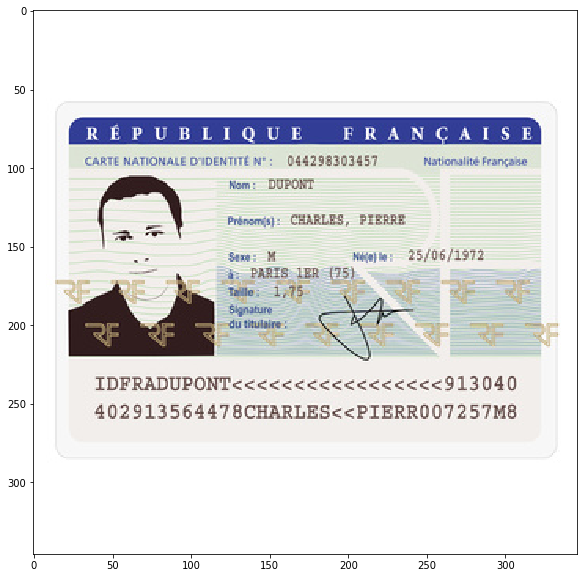

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

In [6]:
edged, eq = detect_edge(img)

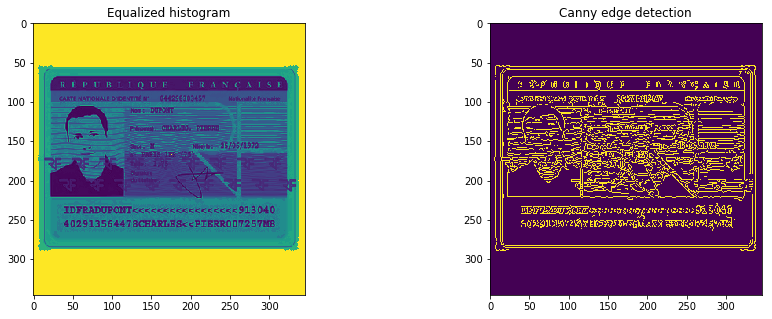

In [7]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(eq)
plt.title('Equalized histogram')
plt.subplot(122)
plt.imshow(edged)
plt.title('Canny edge detection')
plt.show()

In [8]:
_, contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE,  cv2.CHAIN_APPROX_SIMPLE)

In [9]:
# loop over our contours
h, w = img.shape[:2]
thresh_area = 0.001
list_contours = list()
for c in contours:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    area = cv2.contourArea(c)

    # if our approximated contour has four points, then
    # we can assume that we have found our screen
    if (area > thresh_area*h*w): 
        #if 1: #len(approx) == 4:
        #print(peri, approx, len(approx))
        rect_page = cv2.minAreaRect(c)
        box_page = np.int0(cv2.boxPoints(rect_page))
        #box_page = functions.detection.order_points(box_page)
        list_contours.append(box_page)
        #screenCnt = approx

In [10]:
list_contours = supress_list(list_contours)

In [11]:
list_contours

array([[[ 13, 284],
        [ 13,  57],
        [333,  57],
        [333, 284]],

       [[ 18, 288],
        [ 17, 283],
        [331, 278],
        [332, 284]],

       [[ 14, 186],
        [ 14, 171],
        [ 35, 171],
        [ 35, 186]],

       [[ 22, 220],
        [ 22, 167],
        [115, 167],
        [115, 220]]])

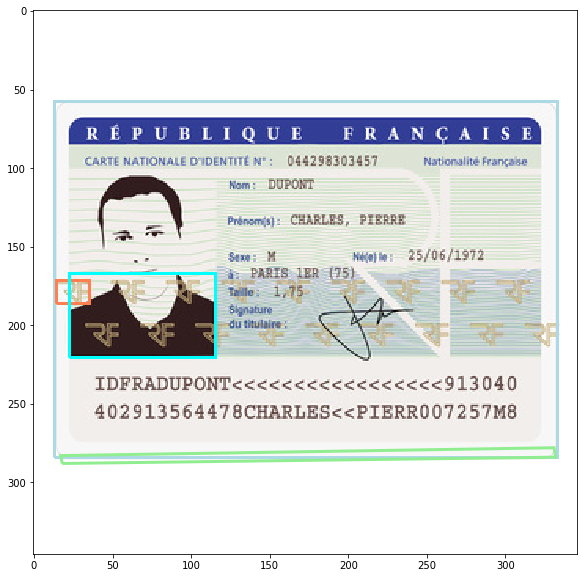

In [12]:
plt.figure(figsize=(10,10))
axr = plt.axes()
axr.imshow(img)
colors = ["lightblue", "lightgreen", "coral", "cyan", "magenta", "yellow", "black","darkblue", "darkgreen", "darkred", "gold", "chocolate", "blue", "green", "red"]
for i, cnt in enumerate(list_contours):
    polygonA = Polygon([(x[0],x[1]) for x in  cnt])
    patch = PolygonPatch(polygonA, fc='none', ec=colors[i%13], lw=3)
    axr.add_patch(patch)

In [13]:
top, bottom, left, right = find_extremes(list_contours[0])

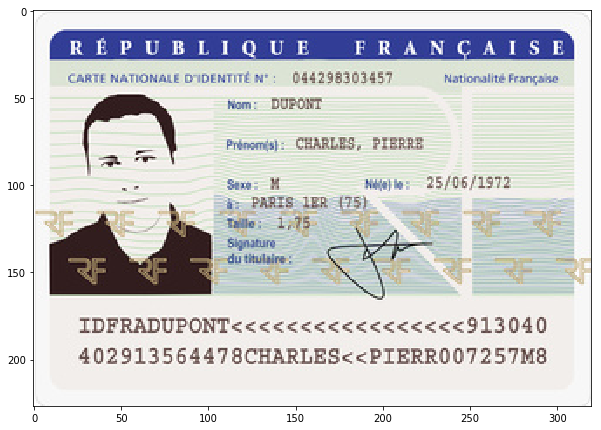

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(img[top:bottom, left:right])
plt.show()

In [15]:
plt.imsave(arr=img[top:bottom, left:right], fname='save.png')

# Change background

In [133]:
# Take the biggest contour
c = max(list_contours, key=cv2.contourArea)

In [134]:
# Initialize mask and fill with contour
mask = np.zeros(img.shape, dtype=np.uint8)
mask = cv2.fillPoly(img=img.copy(), pts=c.reshape(1, -2, 2), color=(0,0,0))
masked_image = cv2.bitwise_and(img, ~mask)

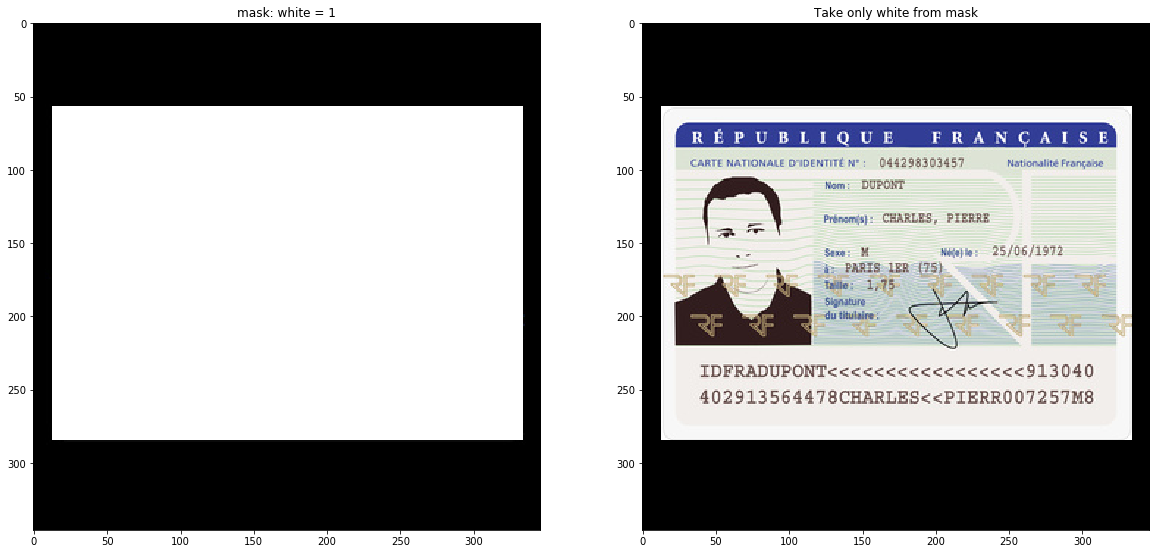

In [141]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.title('mask: white = 1')
plt.imshow(~mask)
plt.subplot(122)
plt.title('Take only white from mask')
plt.imshow(masked_image)

In [142]:
# Initialize background
background = np.zeros(img.shape, dtype=np.uint8)
background[:,:,:] = 128
masked_bg = cv2.bitwise_and(background, mask)

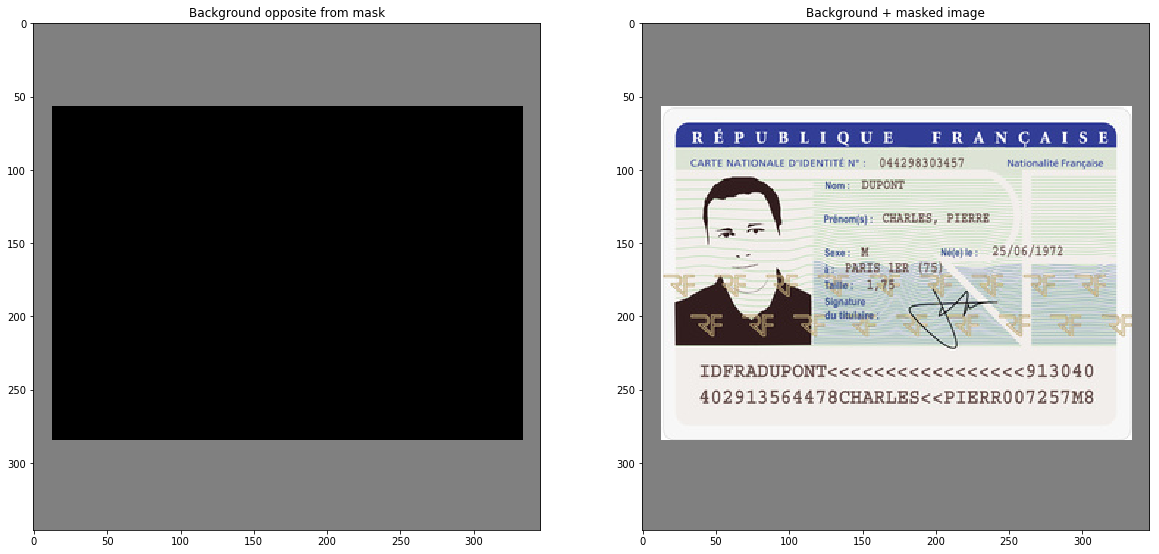

In [144]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.title('Background opposite from mask')
plt.imshow(masked_bg)
plt.subplot(122)
plt.title('Background + masked image')
plt.imshow(cv2.add(masked_image, masked_bg))